In [1]:
import numpy as np
from math import sqrt,log10, log
import pylab as plt

from scipy import optimize as opt

from profiles import build_profile, build_kernel
from dispersion import SphericalJeansDispersion
from likelihood import GaussianLikelihood
#from fitter import MinuitFitter

%matplotlib inline

In [2]:
directory = '/home/andrea/Desktop/work/DWARF/dsphsim/'
rh = 0.04
D = 39.81
theta = 2*rh/D
dwarf_props = {'D':D, 'theta':theta, 'rt':np.inf}

## True values

In [3]:
dm_true = build_profile('NFW')
rvmax = 0.757
vmax = 10.4
rs = rvmax/2.163
rhos = 4.625 * (vmax/rs)**2 / (4*np.pi*4.302e-6)
dm_true.r0 = rs
dm_true.rho0 = rhos
Jtrue = log10(dm_true.Jfactor(**dwarf_props))
print 'rs = %.2f, rhos = %.2e, J = %g'%(rs,rhos,Jtrue)

rs = 0.35, rhos = 7.55e+07, J = 16.724


In [4]:
dm = build_profile('NFW', r0=rs)
st = build_profile('plummer',rh=rh) # Plummer Stellar profile
kr = build_kernel('iso') # isotropic kernel
Sigma = SphericalJeansDispersion(dm, st, kr, dwarf_props)

In [5]:
#R, v = np.loadtxt(directory+'Ret2_data/dsph_001.txt',usecols=(5, 7),unpack=True)
R, v = np.load('results/equiRdSphs.npy')
vnan = np.isnan(v)
v = v[~vnan]
R = R[~vnan]
dv = np.zeros_like(v)

In [6]:
LL = GaussianLikelihood([R, v, dv, 0.], Sigma)
LL.set_free('dm_a')
LL.set_free('dm_b')
LL.set_free('dm_c')
LL.set_free('dm_r0')
#LL.set_free('ker_beta')

In [7]:
parameters = [par.split('_')[-1] for par in LL.free_pars.keys()]
parameters

['a', 'b', 'J', 'r0', 'c']

In [62]:
sqrt(50e5)*16500/sqrt(1e5)/3600.

32.40906080438343

In [15]:
a = 3.23910377e-02
b = 1.60586642e+00
c = 5.86904904e-01
r = 1.26506512e-03
J = 16
Lmin = 1197.2934302071785

In [16]:
p_arr, L_arr = np.load( 'results/aL16.npy')

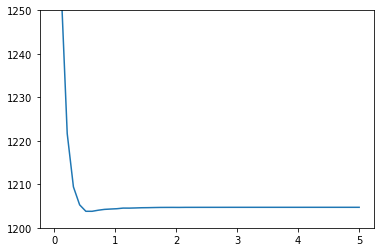

In [17]:
plt.plot(p_arr, L_arr);
plt.plot(a, Lmin, '*');
plt.ylim(1200,1250);

In [74]:
interp_L = interp(J_arr, L_arr-L_arr.min())
for par in parameters:
    exec( 'interp_{0} = interp(J_arr, {0}_arr)'.format(par))

In [75]:
parameters

['a', 'b', 'J', 'c', 'r0']

In [76]:
eval_Like_J = np.linspace(J_arr.min(), J_arr.max(), 1e3)
min_Like_J = interp_L(eval_Like_J).min()
Jmin = eval_Like_J[ np.where( interp_L(eval_Like_J) == min_Like_J )[0][0] ]
J_plt = np.linspace(J_arr.min(),J_arr.max())

In [77]:
Jr = float(interp_r0(Jmin))
Ja = float(interp_a(Jmin))
Jb = float(interp_b(Jmin))
Jc = float(interp_c(Jmin))
#Jbeta = float(interp_beta(Jmin))

In [78]:
dm.r0 = Jr
dm.a = Ja
dm.b = Jb
dm.c = Jc
minrho = lambda rho : abs(Jmin - np.log10( dm.Jfactor(**dwarf_props) ) - 2*rho)
Jrho = float(10**minimize_scalar(minrho).x)

In [79]:
print 'r = %.2f, rho = %.2e, a = %.2f, b = %.2f, c = %.2f'%(Jr, Jrho, Ja, Jb, Jc)
#print 'r = %.2f, rho = %.2e , c = %.2f'%(Jr, Jrho ,Jc)

r = 0.28, rho = 1.56e+08, a = 0.47, b = 3.25, c = 0.96


In [80]:
for i,c in enumerate([0.5,2.0,4.5]):
    exec('J%ssL = %.2f'%(i+1, brentq(lambda j : interp_L(j)-c, J_arr.min(), Jmin) - Jmin))
    exec('J%ssR = %.2f'%(i+1, brentq(lambda j : interp_L(j)-c, Jmin, J_arr.max()) - Jmin))

ValueError: f(a) and f(b) must have different signs

NameError: name 'J3sL' is not defined

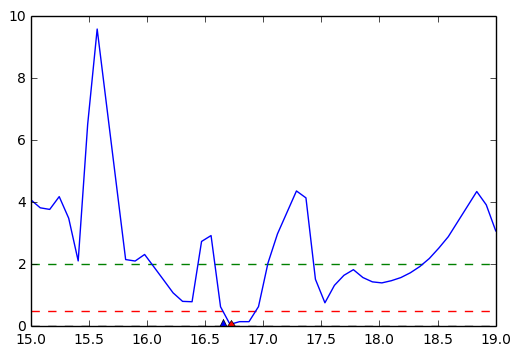

In [81]:
plt.plot(J_plt, interp_L(J_plt))
plt.hlines(0, J_plt.min(), J_plt.max(), linestyles='dashed')
plt.plot(Jmin, 0, 'b^', markersize=10, label=r'$\mathcal{J}_{MLE}$ = %.2f'%Jmin)
plt.plot(16.72, 0, 'rd', markersize=6, label=r'$\mathcal{J}_{TRUE}$ = 16.72')
for i,(c,h) in enumerate(zip(['r','g','c'],[0.5,2.0,4.5])):
    JL, JR = eval('J%ssL'%str(i+1)), eval('J%ssR'%str(i+1))
    plt.hlines(h, J_plt.min(), J_plt.max(), linestyles='dashed', colors=c,
              label=r'$%i-\sigma$'%(i+1)+'\t'+'[%2s,%2s]'%(str(JL),str(JR)))
plt.legend(numpoints=1,fontsize=14).get_frame().set_facecolor('w')
plt.text(15.5, 7,'a = %.2f (1)'%Ja +'\n'+
                 'b = %.2f (3)'%Jb +'\n'+
                 'c = %.2f (1)'%Jc +'\n'+
                 r'$r_s$ = %.2f (0.35)'%Jr +'\n'+
                 r'$\rho_s$ = %.2e'%Jrho +'\n     (7.55e+07)')

plt.ylim(-0.5,20);
#plt.xlim(16.3,17.5);
#plt.savefig('results/LikeJ_rabc_20p.png',format='png',dpi=300);